In [1]:
import torch
import torch_geometric
import time
import warnings
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from utils import filling, kmeans_clustering, plot_clusters
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GAE

warnings.filterwarnings('ignore')

In [2]:
print(torch.__version__)
print(torch_geometric.__version__)

2.0.1+cpu
2.3.1


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
data = torch.load('Data/santiago_zero_ismt.pt')
data.comuna = data.x[:, 8]
data.ismt = data.x[:,-1]
data.lat = data.x[:,0]
data.lon = data.x[:,1]
data.x = data.x[:, 2:8]
print(data)
print(data.x)
print(data.lat)
print(data.comuna)
print(data.ismt)
print(data.edge_index)
print(data.edge_attributes)

Data(x=[355936, 6], edge_index=[2, 673565], edge_attributes=[673565, 2], comuna=[355936], ismt=[355936], lat=[355936], lon=[355936])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.5074, -1.1100, -1.6402,  1.2143,  1.6439,  1.6780],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
tensor([-33.4416, -33.4420, -33.4429,  ..., -33.4390, -33.4389, -33.4386])
tensor([39., 39., 39.,  ..., 42., 42., 42.])
tensor([0.8805, 0.8805, 0.8594,  ..., 0.8625, 0.8625, 0.8625])
tensor([[     0,      1,      2,  ..., 355934, 355935, 355935],
        [  4463,   4467,    488,  ..., 191461, 251187,   7949]])
tensor([[80.8500,  5.8000],
        [18.8300,  1.3000],
        [16.0600,  1.1000],
        ...,
        [33.0400,  4.1000],
        [ 2.5300,  0.2000],
    

In [5]:
n_nodes, n_features = data.x.shape
print(n_nodes, n_features)

355936 6


In [6]:
n_nodes, n_features = data.x.shape
num_iterations = 40


missing_feature_mask = torch.where(data.x == 0, 0.0, 1.0).bool().to(device)
x = data.x.clone()
x[~missing_feature_mask] = float("nan")

print("Starting feature filling")
start = time.time()
filled_features = (
    filling("feature_propagation", data.edge_index, x, missing_feature_mask, num_iterations,)
    if "gcn" not in ["gcnmf", "pagnn"]
    else torch.full_like(x, float("nan"))
)
print(filled_features)
print(f"Feature filling completed. It took: {time.time() - start:.2f}s")
data.x = torch.where(missing_feature_mask, data.x, filled_features)

Starting feature filling
tensor([[-1.8762,  0.0880,  1.8812, -0.7552, -2.0797, -1.2788],
        [ 0.2155, -0.1407, -0.2000,  0.7840,  0.9977,  0.7484],
        [ 0.0507, -1.1760, -0.3934,  1.3322,  0.4679,  0.7087],
        ...,
        [ 1.0445, -1.0450, -1.3092,  1.1516,  1.1633,  1.0873],
        [ 1.5074, -1.1100, -1.6402,  1.2143,  1.6439,  1.6780],
        [ 1.2992, -0.1245, -1.1497,  0.2336,  1.0391,  0.9675]])
Feature filling completed. It took: 2.07s


In [7]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

In [9]:
def trainGAE(data, num_features, edge_input_dim, out_channels, epochs=100, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    x = data.x
    edge_attr = torch.tensor(data['edge_attributes'], dtype=torch.float)
    edge_index = torch.tensor(data['edge_index'], dtype=torch.long)

    # Construir el grafo de PyTorch Geometric Data
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    # Cargar los datos en un DataLoader
    loader = DataLoader([graph_data], batch_size=1)

    #model = GraphAutoencoder(node_input_dim, edge_input_dim, hidden_dim, latent_dim).to(device)
    model = GAE(GCNEncoder(num_features, out_channels))
    criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Entrenamiento del modelo
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            #output = model(data.x, data.edge_attr, data.edge_index)
            z = model.encode(x, edge_index)
            loss = model.recon_loss(z, edge_index)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader)}")

    model.eval()
    with torch.no_grad():
        latent_representation = model.encode(x, edge_index)

    return latent_representation.cpu().numpy()

In [21]:
latent = trainGAE(data, num_features=6, edge_input_dim=2, out_channels=2, epochs=20, lr=0.001)

Epoch 1/20, Loss: 1.3352105617523193
Epoch 2/20, Loss: 1.3322950601577759
Epoch 3/20, Loss: 1.3262919187545776
Epoch 4/20, Loss: 1.3234130144119263
Epoch 5/20, Loss: 1.321794033050537
Epoch 6/20, Loss: 1.3172855377197266
Epoch 7/20, Loss: 1.314413070678711
Epoch 8/20, Loss: 1.3101218938827515
Epoch 9/20, Loss: 1.3082884550094604
Epoch 10/20, Loss: 1.3049967288970947
Epoch 11/20, Loss: 1.302039623260498
Epoch 12/20, Loss: 1.2992544174194336
Epoch 13/20, Loss: 1.297952651977539
Epoch 14/20, Loss: 1.295008897781372
Epoch 15/20, Loss: 1.2923719882965088
Epoch 16/20, Loss: 1.2908475399017334
Epoch 17/20, Loss: 1.2861521244049072
Epoch 18/20, Loss: 1.2846753597259521
Epoch 19/20, Loss: 1.282759666442871
Epoch 20/20, Loss: 1.2812608480453491


In [12]:
latitudes = data.lat.tolist()
longitudes = data.lon.tolist()

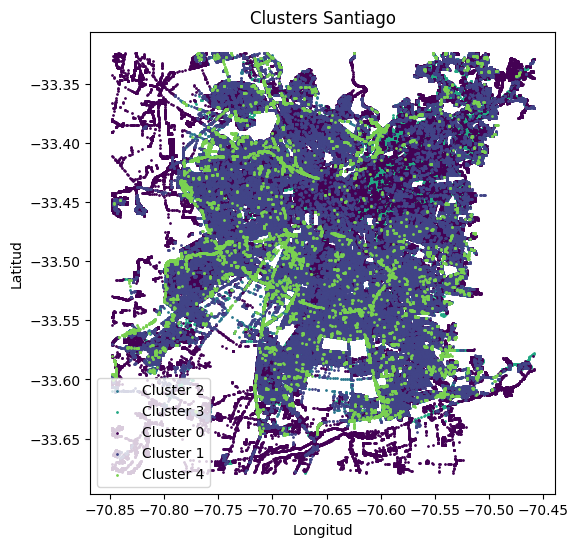

In [25]:
num_clusters = 5
cluster_labels = kmeans_clustering(latent, num_clusters)
plot_clusters(latitudes, longitudes, cluster_labels, node_size=1, c_map='viridis')